# AML Week 2, Lecture 1: Preparing Text for Deep NLP Models (TextVectorization)

## Learning Objectives

- How to create a train-test-val split for Tensorflow datasets from a train-test split. 
- How to use a Keras TextVectorization Layer
- Demonstrate how tensorflow models using Sequences with Embedding Layers.


In [89]:
# Adding parent directory to python path
import os, sys
sys.path.append(os.path.abspath("../"))

In [90]:
## Load the autoreload extension
%load_ext autoreload 
%autoreload 2

import demo  as fn


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [91]:
from IPython.display import display, Markdown
with open("../Data-AmazonReviews/Amazon Product Reviews.md") as f:
    display(Markdown(f.read()))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

In [92]:
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

# MacOS Sonoma Fix
tf.config.set_visible_devices([], 'GPU')

In [93]:
import pandas as pd 
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

In [94]:
import joblib
df = joblib.load('../Data-AmazonReviews/processed_data.joblib')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8191 entries, 0 to 8256
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   overall            8191 non-null   float64
 1   text-raw           8191 non-null   object 
 2   length             8191 non-null   int64  
 3   text               8191 non-null   object 
 4   lower_text         8191 non-null   object 
 5   tokens             8191 non-null   object 
 6   no_stops           8191 non-null   object 
 7   no_stops_no_punct  8191 non-null   object 
 8   spacy_lemmas       8191 non-null   object 
 9   bigrams            8191 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 703.9+ KB


,overall,text-raw,length,text,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams
0,4.0,Not going to show you the dirty water on here because I have shame and it ...: Used it twice already and I have absolutely seen results. Not going to show you the dirty water on here because I have shame and it is gross. I will say that while you...,672,Not going to show you the dirty water on here because I have shame and it ...: Used it twice already and I have absolutely seen results. Not going to show you the dirty water on here because I have shame and it is gross. I will say that while you...,not going to show you the dirty water on here because i have shame and it ...: used it twice already and i have absolutely seen results. not going to show you the dirty water on here because i have shame and it is gross. i will say that while you...,"[not, going, to, show, you, the, dirty, water, on, here, because, i, have, shame, and, it, ..., :, used, it, twice, already, and, i, have, absolutely, seen, results, ., not, going, to, show, you, the, dirty, water, on, here, because, i, have, sha...","[going, show, dirty, water, shame, ..., :, used, twice, already, absolutely, seen, results, ., going, show, dirty, water, shame, gross, ., say, 're, cleaning, ,, leave, place, second, (, instance, ,, 're, moving, plug, new, outlet, ), ,, leak, li...","[going, show, dirty, water, shame, ..., used, twice, already, absolutely, seen, results, going, show, dirty, water, shame, gross, say, 're, cleaning, leave, place, second, instance, 're, moving, plug, new, outlet, leak, little, water, part, sucks...","[go, dirty, water, shame, twice, absolutely, see, result, go, dirty, water, shame, gross, clean, leave, place, second, instance, move, plug, new, outlet, leak, little, water, suck, upward, big, deal, suck, right, happen, end, cleaning, remove, ta...","[(go, dirty), (dirty, water), (water, shame), (shame, twice), (twice, absolutely), (absolutely, see), (see, result), (result, go), (go, dirty), (dirty, water), (water, shame), (shame, gross), (gross, clean), (clean, leave), (leave, place), (place..."
1,5.0,Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...,1021,Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...,makes carpet look brand new!!!: when you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n my carpets were very dirty because i have 2 small dogs that go in and hour all d...,"[makes, carpet, look, brand, new, !, !, !, :, when, you, get, the, shampooer, you, have, to, put, it, together, but, is, very, easy, ..., the, handle, is, the, only, thing, that, you, have, to, attach, ..., my, carpets, were, very, dirty, because...","[makes, carpet, look, brand, new, !, !, !, :, get, shampooer, put, together, easy, ..., handle, thing, attach, ..., carpets, dirty, 2, small, dogs, go, hour, day, ..., 1st, day, got, shampoo, shampooed, entire, house, made, huge, difference, ., w...","[makes, carpet, look, brand, new, get, shampooer, put, together, easy, ..., handle, thing, attach, ..., carpets, dirty, 2, small, dogs, go, hour, day, ..., 1st, day, got, shampoo, shampooed, entire, house, made, huge, difference, week, later, dow...","[make, carpet, look, brand, new, shampooer, easy, handle, thing, attach, carpet, dirty, 2, small, dog, hour, day, 1st, day, get, shampoo, shampoo, entire, house, huge, difference, week, later, downstair, dirt, carpet, shampoo, carpet, look, brian...","[(make, carpet), (carpet, look), (look, brand), (brand, new), (new, shampooer), (shampooer, easy), (easy, handle),

In [95]:
def create_groups(x):
    if x>=5.0:
        return "high"
    elif x <=2.0:
        return "low"
    else: 
        return None

To understand what customers do and do not like about Hoover products, we will define 2 groups:
- High Ratings
    - Overall rating = 5.0
- Low Ratings
    - Overall rating = 1.0 or 2.0


We can use a function and .map to define group names based on the numeric overall ratings.

In [96]:
## Use the function to create a new "rating" column with groups
df['rating'] = df['overall'].map(create_groups)
df.head()

,overall,text-raw,length,text,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams,rating
0,4.0,Not going to show you the dirty water on here because I have shame and it ...: Used it twice already and I have absolutely seen results. Not going to show you the dirty water on here because I have shame and it is gross. I will say that while you...,672,Not going to show you the dirty water on here because I have shame and it ...: Used it twice already and I have absolutely seen results. Not going to show you the dirty water on here because I have shame and it is gross. I will say that while you...,not going to show you the dirty water on here because i have shame and it ...: used it twice already and i have absolutely seen results. not going to show you the dirty water on here because i have shame and it is gross. i will say that while you...,"[not, going, to, show, you, the, dirty, water, on, here, because, i, have, shame, and, it, ..., :, used, it, twice, already, and, i, have, absolutely, seen, results, ., not, going, to, show, you, the, dirty, water, on, here, because, i, have, sha...","[going, show, dirty, water, shame, ..., :, used, twice, already, absolutely, seen, results, ., going, show, dirty, water, shame, gross, ., say, 're, cleaning, ,, leave, place, second, (, instance, ,, 're, moving, plug, new, outlet, ), ,, leak, li...","[going, show, dirty, water, shame, ..., used, twice, already, absolutely, seen, results, going, show, dirty, water, shame, gross, say, 're, cleaning, leave, place, second, instance, 're, moving, plug, new, outlet, leak, little, water, part, sucks...","[go, dirty, water, shame, twice, absolutely, see, result, go, dirty, water, shame, gross, clean, leave, place, second, instance, move, plug, new, outlet, leak, little, water, suck, upward, big, deal, suck, right, happen, end, cleaning, remove, ta...","[(go, dirty), (dirty, water), (water, shame), (shame, twice), (twice, absolutely), (absolutely, see), (see, result), (result, go), (go, dirty), (dirty, water), (water, shame), (shame, gross), (gross, clean), (clean, leave), (leave, place), (place...",None
1,5.0,Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...,1021,Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...,makes carpet look brand new!!!: when you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n my carpets were very dirty because i have 2 small dogs that go in and hour all d...,"[makes, carpet, look, brand, new, !, !, !, :, when, you, get, the, shampooer, you, have, to, put, it, together, but, is, very, easy, ..., the, handle, is, the, only, thing, that, you, have, to, attach, ..., my, carpets, were, very, dirty, because...","[makes, carpet, look, brand, new, !, !, !, :, get, shampooer, put, together, easy, ..., handle, thing, attach, ..., carpets, dirty, 2, small, dogs, go, hour, day, ..., 1st, day, got, shampoo, shampooed, entire, house, made, huge, difference, ., w...","[makes, carpet, look, brand, new, get, shampooer, put, together, easy, ..., handle, thing, attach, ..., carpets, dirty, 2, small, dogs, go, hour, day, ..., 1st, day, got, shampoo, shampooed, entire, house, made, huge, difference, week, later, dow...","[make, carpet, look, brand, new, shampooer, easy, handle, thing, attach, carpet, dirty, 2, small, dog, hour, day, 1st, day, get, shampoo, shampoo, entire, house, huge, difference, week, later, downstair, dirt, carpet, shampoo, carpet, look, brian...","[(make, carpet), (carpet, look), (look, brand), (brand, new), (new, shampooer), (shampooer, easy), (ea

In [97]:
df['rating'].value_counts(dropna=False)

high    5547
None    1832
low      812
Name: rating, dtype: int64

In [98]:
## Check class balance of 'rating'
df['rating'].value_counts(normalize=True)

high    0.872307
low     0.127693
Name: rating, dtype: float64

In [99]:
# Create a df_ml without null ratings
df_ml = df.dropna(subset=['rating']).copy()
df_ml.isna().sum()

overall              0
text-raw             0
length               0
text                 0
lower_text           0
tokens               0
no_stops             0
no_stops_no_punct    0
spacy_lemmas         0
bigrams              0
rating               0
dtype: int64

In [100]:
## X - Option A)  lemmas
# def join_tokens(token_list):
#     joined_tokens = ' '.join(token_list)
#     return joined_tokens
# X = df_ml['spacy_lemmas'].apply(join_tokens)

# X - Option B) original raw text
X = df_ml['text']

# y - use our binary target 
y = df_ml['rating']
X.head(10)

1     Makes carpet look brand new!!!: When you get the shampooer you have to put it together but is very easy...the handle is the only thing that you have to attach...\n\n My carpets were very dirty because I have 2 small dogs that go in and hour all d...
4     VERY DISAPPOINTED: WORKED for maybe 1/2 hr and then it appeared the motor got hot and shut off and 10 secs later would start again and would work for 10 or 15 secs and quit again.......sending it back to HOOVER this week......I was VERY DISAPPOIN...
5                                                                 Perfect!: I love this cleaner!  It's easy to operate, light enough to manipulate and easy to clean. The tank holds plenty of shampoo and water solution and the suction for removal is great.
6     Wow - way exceeded expectations: I had the older model from probably 2001 and it was great for the occasional pet stain or the muddy paw prints on white carpet situation, but it was not for routine cleaning.  It finally konked

In [101]:
y.value_counts(normalize=True)

high    0.872307
low     0.127693
Name: rating, dtype: float64

# 📚 New For Today:

- Starting with a simple train-test-split for ML model (like in movie nlp project)
- Resampling Imbalanced training data
- Creating tensorflow dataset from X_train, y_train (so dataset is rebalanced)
- Creating tensorflow dataset (intended to be split in 2 ) for X_test and y_test

## From Train-Test Split for ML to Train-Test-Val Split for ANNs

In [102]:
# Perform 70:30 train test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.3, random_state=42)
len(X_train_full), len(X_test)

(4451, 1908)

### Using Sklearn's LabelEncoder

- Can't use text labels with neural networks.

In [103]:
y_train_full[:10]

3889    high
3254    high
2996    high
3790    high
3764    high
7301    high
2449    high
430     high
2296    high
2321     low
Name: rating, dtype: object

In [104]:
# Instansiate label encoder
encoder = LabelEncoder()

# Fit and transform the training target
y_train_full_enc = encoder.fit_transform(y_train_full)#.values)

# Fit and tranform the test target
y_test_enc = encoder.transform(y_test)

y_train_full_enc[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [105]:
# Original Class names saved as .classes_
classes = encoder.classes_
classes

array(['high', 'low'], dtype=object)

In [106]:
# Can inverse-transform 
encoder.inverse_transform([0,1])

array(['high', 'low'], dtype=object)

### Undersampling Majority Class

In [107]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate a RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)

In [108]:
try:
    X_train, y_train = sampler.fit_resample(X_train_full,y_train_full_enc)
except Exception as e:
    display(e)

ValueError('Expected 2D array, got 1D array instead:\narray=[\'Really like it!: Love this!  No more pulling out the vacuum cleaner from the garage and plugging it in 3 different places to get the whole room.  Suction is great, very compact and nice handling.  We will see if it holds up.  I did buy the extended warranty for 6 bucks due to some of the reviews.  But if I had to spend 100 on a new one every year I would.\'\n \'which is awesome.: My last carpet cleaner broke so I bought this one after reading the reviews. It cleans very well! My carpet dries in about 30 minutes, which is awesome.\'\n \'seriously powerful: This is our second of these vacuums- we liked the first so much that we decided to get a second one for the second floor of our house.  This is the only "stick vac" we have found that can compete with our Dyson. We have four cats, three birds, and a ten year old daughter with very long hair, plus a garden we track leaves and dirt in from, so we\\\'re constantly (and I do m

In [109]:
# Fit_resample on the reshaped X_train data and y-train data
X_train, y_train_enc = sampler.fit_resample(X_train_full.values.reshape(-1,1),
                                        y_train_full_enc)
X_train.shape

(1118, 1)

In [110]:
# Flatten the reshaped X_train data back to 1D
X_train = X_train.flatten()
X_train.shape

(1118,)

In [111]:
# Check for class balance
pd.Series(y_train_enc).value_counts()

0    559
1    559
dtype: int64

## Previous Class' ML Model

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.pipeline import Pipeline
# from sklearn.naive_bayes import MultinomialNB

In [ ]:
# ## Create a model pipeline 
# count_pipe = Pipeline([('vectorizer',  CountVectorizer()), 
#                        ('naivebayes',  MultinomialNB())])

# count_pipe.fit(X_train, y_train_enc)
# fn.evaluate_classification(count_pipe, X_train, y_train_enc, X_test, y_test_enc,)

# Preparing For Deep NLP (Train-Test-Val Datasets)

## 🕹️ Prepare Tensorflow Datasets

Since we already have train/test X and y vars, we will make 2 dataset objects using tf.data.Dataset.from_tensor_slices.

1. The training dataset using X_train, y_train (that we resampled/balanced)
2. The val/test dataset using X_test, y-test.

We will then split the val/test dataset into a val/test split.

<!-- 
### T/T/V Split - Order of Operations (if using 1 dataset object)

1) **Create full dataset object & Shuffle Once.**
2) Calculate number of samples for training and validation data.
3) Create the train/test/val splits using .take() and .skip()
4) **Add shuffle to the train dataset only.**
5) (Optional/Not Used on LP) If applying a transformation (e.g. train_ds.map(...)) to the data, add  here, before .cache()
7) (Optional) Add .cache() to all splits to increase speed  (but may cause problems with large datasets)
8) **Add .batch to all splits (default batch size=32)**
9) (Optional) Add .prefetch(tf.data.AUTOTUNE)
10) (Optional) Print out final length of datasets -->

In [112]:
# Convert training data to Dataset Object
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
# Shuffle dataset once
train_ds = train_ds.shuffle(len(train_ds), reshuffle_each_iteration=False)

Create a test and validation dataset using X_test,y_test

In [113]:
# Convert test to dataset object to split
val_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))

In [114]:
# Calculate # of samples for 50/50 val/test split
n_val_samples = int(len(val_test_ds) *.5)
n_val_samples

954

In [115]:
## Perform the val/test split

## Create the validation dataset using .take
val_ds = val_test_ds.take(n_val_samples)

## Create the test dataset using skip
test_ds = val_test_ds.skip(n_val_samples)

In [116]:
# Comparing the len gths of all 3 splits
len(train_ds), len(val_ds), len(test_ds)

(1118, 954, 954)

### Adding Shuffling and Batching

Let's examine a single element.

In [117]:
# display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b'Easy, Fast and does a Good Job: Easy to use, fast set-up.  It did a great job on the carpet I wanted to rescue.', shape=(), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64)


In [118]:
# (Repeat) display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b'Easy, Fast and does a Good Job: Easy to use, fast set-up.  It did a great job on the carpet I wanted to rescue.', shape=(), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64)


Notice that we have the same example, the training data is not shuffling.

Add .shuffle the training data.

In [120]:
# Shuffle only the training data every epoch
train_ds = train_ds.shuffle(len(train_ds))

In [121]:
# (Repeat) display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b'"HORRIBLE PRODUCT" HOOVER FH50150 CARPET BASICS POWER SCRUB-deluxe: This scrubber is "HORRIBLE"!!!!!\nI took it out of the box assembled it...went on line June 15, 2016 and registered it.\nI USED IT July 1st.  NEVER, NEVER, NEVER HAVE I HAD TO WORK SO HARD TO\nCLEAN  "A"  AS IN ONE ROOM OF CARPET!!!!! (APPROXIMATELY 14X20)\nI INTENDED TO DO THE HALL WAY AND BEDROOM...NO WAY!!!!!!\nMY RIGHT ARM ...HAND ... SHOULDER ... MY NECK "HURT SO BAD"!!!!!\nYOU HAVE TO SWITCH FROM WASH TO RINSE OVER AND OVER.\nTHE WATER RESERVOIR FOR THE CLEAN WATER IS SOOOOO SMALL.  I HAD TO KEEP REFILLING IT!!!\nTHE RESERVOIR IS SEMI CLEAR GREY AND VERY HARD TO SEE THROUGH.  I KEPT RUNNING OUT OF\nWATER AND "DID NOT KNOW IT" AT FIRST....SOOOOO I HAD TO KEEP CHECKING THAT.\nTHE RESERVOIR FOR THE DIRTY WATER ALSO IS VERY SMALL ...(YES DIRTY WATER) ... THAT IS WHY I PURCHASED A "CARPET SCRUBBER".\nI ALSO CAN NOT BELIEVE "AMAZON" RECOMMENDED THIS ~ HOOVER FH50150 CARPET BASICS POWER SCRUB-deluxe!\nI AM F

In [122]:
# (Repeat) display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b"Works OK - Battery Life is Poor: The main thing about this device is that if you don't use it all the time and keep the battery charged, the battery will discharge in storage very quickly, so when you need it chances are it will be dead or nearly dead.\n\nThe actual vacuum itself works pretty well aside from the battery issue.", shape=(), dtype=string) 

 tf.Tensor(1, shape=(), dtype=int64)


> Add batching (use 32 for batch_size)

In [123]:
#  Setting the batch_size for all datasets
BATCH_SIZE =32
# use .batch to add batching to all 3 datasets
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 35 training batches.
 There are 30 validation batches.
 There are 30 testing batches.


In [124]:
# (Repeat) display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)


tf.Tensor(
[b'Lasted 1 use before water started leaking out the bottom: After seeing the good reviews for this product, I bought this steamer to replace a similar Hoover model that lasted 15-20 years.  This product lasted for one cleaning.  It did not do a very good job cleaning.  My old steamer was much better at removing dirt.  The second time I tried to use it, water started pouring out of the bottom.  I ended up throwing it in the trash.  Then I noticed similar reviews for this product from many people that had the same problem.  Apparently, it is a roll of the dice with this steamer.  Some people seem to have gotten a good product.  The one I, and many others got was a lemon.  I would not take a chance a second time with such poor quality control.'
 b"Leaking after 10 months: So the product itself is strong and does a great job at cleaning pet stains on the carpet. The bad side is after 10 months the Hoover SteamVac developed a leak when waiting to be used again. WORSE yet, hoover

A single element now contains 32 samples since we set  batch_size to 32.

## 📚 Vectorizing Text with Keras's TextVectorization Layer (Demo)
### Compare what is happening during text vectorization when using count versus sequence

Flexible layer that can convert text to bag-of-words or sequences.

In [125]:
# Example text for demo 
example_text = ['Sometimes I love this vacuum, sometimes i hate this vacuum']

### TextVectorization Layer - Demo Count Vectorization

In [126]:
# Create text Vectorization layer - set to count vectorization
count_vectorizer = tf.keras.layers.TextVectorization(output_mode='count')

In [127]:
# Get the vocabulary from the vectorization layer.
count_vectorizer.get_vocabulary()

['[UNK]']

- Before training, only contains the out of vocab token ([UNK])

In [128]:
# Fitting the vectorizer using .adapt
count_vectorizer.adapt(example_text)
# Check the vocabulary after training the layer.
count_vectorizer.get_vocabulary()

['[UNK]', 'vacuum', 'this', 'sometimes', 'i', 'love', 'hate']

In [129]:
# Convert example to count-vectorization
counts = count_vectorizer(example_text)
counts

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=array([[0., 2., 2., 2., 2., 1., 1.]], dtype=float32)>

- Size of vectorized text - column for every word in vocab

In [130]:
# Getting the counts as as DataFrame 
pd.DataFrame(counts.numpy(), columns=count_vectorizer.get_vocabulary())

,[UNK],vacuum,this,sometimes,i,love,hate
0,0.0,2.0,2.0,2.0,2.0,1.0,1.0


### TextVectorization Layer - Demo Sequence Vectorization

- Output_mode='int' returns sequences.
- Length is set by data scientist, use 20 for demo

In [131]:
# Create text Vectorization layer for sequences
sequence_vectorizer = tf.keras.layers.TextVectorization(output_mode='int',output_sequence_length=20)

In [132]:
# Check the vocabulary of the new sequence vectorizer.
vocab =  sequence_vectorizer.get_vocabulary()
vocab

['', '[UNK]']

- Before training, only contains the out of vocab token ([UNK])

In [133]:
# Fit the vectorizer using .adapt
sequence_vectorizer.adapt(example_text)
# Check the vocabulary after training the layer
vocab =  sequence_vectorizer.get_vocabulary()
vocab

['', '[UNK]', 'vacuum', 'this', 'sometimes', 'i', 'love', 'hate']

To demonstrate how sequences are used, we will make a dictionary with the integer code as the key and the corresponding word as the value

In [134]:
# Save dictionaries to look up words from ints 
int_to_str  = {idx:word for idx, word in enumerate(vocab)} # Dictionary Comprehension
int_to_str

{0: '',
 1: '[UNK]',
 2: 'vacuum',
 3: 'this',
 4: 'sometimes',
 5: 'i',
 6: 'love',
 7: 'hate'}

In [135]:
# Convert example to sequences
sequences = sequence_vectorizer(example_text)
sequences

<tf.Tensor: shape=(1, 20), dtype=int64, numpy=array([[4, 5, 6, 3, 2, 4, 5, 7, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

- Why are there 0s at the end of the sequence?

In [136]:
# Cannot be made into a dataframe
try:
    pd.DataFrame(sequences, columns = vocab)
except Exception as e:
    display(e)

ValueError('Shape of passed values is (1, 20), indices imply (1, 8)')

In [137]:
# save the sequences as numpy array for the loop below
sequences = sequences.numpy()
sequences

array([[4, 5, 6, 3, 2, 4, 5, 7, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [138]:
# For each integer code, display the corresponding word
for val in sequences[0]:
    print(f"{val} = {int_to_str[val]}")

4 = sometimes
5 = i
6 = love
3 = this
2 = vacuum
4 = sometimes
5 = i
7 = hate
3 = this
2 = vacuum
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 


##  Embedding Layer

In [139]:
# Saving the Size of the Vocab
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

8

The embedding layer needs the number of words in the input (input_dim), and the desired embedding dimensions. (e.g. 100,200,300).


In [140]:
# Create embedding layer of desired # of values
EMBED_DIM = 50
embedding_layer = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                           output_dim=EMBED_DIM,
                                           input_length= 20)
embedding_layer

### Demonstrating Sequence to Vector Embedding Lookup 

In [141]:
# Minimum Model Needed to Create Embedding Layer for Vocab
demo_embed = Sequential()
demo_embed.add(sequence_vectorizer)
demo_embed.add(embedding_layer)
demo_embed.compile(optimizer='adam', loss='mse')
demo_embed.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_5 (TextV  (None, 20)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 20, 50)            400       
                                                                 
Total params: 400
Trainable params: 400
Non-trainable params: 0
_________________________________________________________________


In [142]:
# Embedding has row per word with EMBED_DIM of 50
sequence_vectorizer.vocabulary_size(), EMBED_DIM

(8, 50)

In [143]:
# Get the weights from the embedding layer (this is your actual embedding matrix)
embedding_weights = demo_embed.layers[1].get_weights()[0]
embedding_weights

array([[ 3.58189084e-02,  1.62628554e-02, -1.41289234e-02,
         4.49989550e-02, -4.21938896e-02,  1.52332298e-02,
         4.70499881e-02, -3.32087874e-02,  2.37892941e-03,
         1.30759589e-02, -4.13581729e-02, -5.36425039e-03,
         4.66033705e-02, -2.96588987e-03,  2.94636935e-04,
         2.65665986e-02, -4.81170081e-02, -3.07619106e-02,
         1.42415613e-03, -4.33575287e-02, -4.62355018e-02,
         3.47966589e-02,  4.15427946e-02, -2.37459186e-02,
         3.59531902e-02, -3.72525454e-02, -3.77146155e-03,
         6.27218559e-03,  6.66918606e-03, -2.99837943e-02,
        -2.90307291e-02,  4.89163883e-02, -3.90107036e-02,
        -5.63867018e-03, -2.34911442e-02, -3.78978737e-02,
         2.33143009e-02, -3.17659378e-02,  1.81295760e-02,
         1.50418989e-02, -4.57369201e-02,  6.36358187e-03,
        -1.65878311e-02, -1.13153234e-02,  4.54521440e-02,
        -8.96059349e-03,  3.14701721e-03, -2.44680289e-02,
        -3.77182849e-02,  2.15829946e-02],
       [ 1.16

In [144]:
# Preview one set of embedding weights
embedding_weights[0]

array([ 0.03581891,  0.01626286, -0.01412892,  0.04499895, -0.04219389,
        0.01523323,  0.04704999, -0.03320879,  0.00237893,  0.01307596,
       -0.04135817, -0.00536425,  0.04660337, -0.00296589,  0.00029464,
        0.0265666 , -0.04811701, -0.03076191,  0.00142416, -0.04335753,
       -0.0462355 ,  0.03479666,  0.04154279, -0.02374592,  0.03595319,
       -0.03725255, -0.00377146,  0.00627219,  0.00666919, -0.02998379,
       -0.02903073,  0.04891639, -0.0390107 , -0.00563867, -0.02349114,
       -0.03789787,  0.0233143 , -0.03176594,  0.01812958,  0.0150419 ,
       -0.04573692,  0.00636358, -0.01658783, -0.01131532,  0.04545214,
       -0.00896059,  0.00314702, -0.02446803, -0.03771828,  0.02158299],
      dtype=float32)

In [145]:
embedding_weights.shape


(8, 50)

In [146]:
# Show embeddings for each token in the sequence
for val in sequences[0]:
    print(f"{val} = {int_to_str[val]}")
    print(embedding_weights[val])
    print()

4 = sometimes
[-0.03049665  0.00108702  0.00453812  0.02154781 -0.03100958 -0.03011968
 -0.0484815  -0.01406106 -0.00686682  0.03288065  0.00214293 -0.04245937
 -0.04426146  0.02529577 -0.02883911 -0.03555089  0.00704191 -0.03155373
  0.01291392 -0.01290181 -0.0054871  -0.03120226  0.02276422 -0.04641331
 -0.01572597 -0.01439481  0.01411927  0.01416272 -0.00952171 -0.03483657
 -0.02252584  0.00511599  0.01547125 -0.01732833  0.01645075 -0.02833271
 -0.02591774  0.01548456 -0.03494944  0.01763118  0.02025503 -0.01325465
  0.00073957  0.0388776   0.03557179  0.02644011 -0.02132853  0.02692893
  0.0331666  -0.02804074]

5 = i
[-0.00716971  0.00678831 -0.00871501 -0.04269713  0.03735954  0.04830888
  0.00964015 -0.04125384  0.02160454  0.01335058 -0.02282237 -0.0057681
  0.03451191  0.00235753 -0.04606862  0.00248938 -0.01421291  0.0194427
  0.04137533 -0.02454375 -0.03914202  0.02792576 -0.01166707  0.04981508
  0.02564709  0.04478588 -0.03594257  0.03367301  0.0178873   0.00370115
  0.00

# LECTURE 1 STOP HERE

### Word Vectors Math

In [147]:
# Prepare the words and their corresponding vectors
vector_dict = {}
for i, word in int_to_str.items():#tokenizer.word_index.items():
    # Save the weights for word (based on numeric index)
    vector_dict[word]= embedding_weights[i] 

    # vector_list.append(embedding_weights[i])
vector_dict.keys()

dict_keys(['', '[UNK]', 'vacuum', 'this', 'sometimes', 'i', 'love', 'hate'])

In [148]:
# Display the vector for "love"
vector_dict['love']

array([ 0.01521034,  0.00402517,  0.00980352, -0.01194083, -0.03935908,
       -0.03924141,  0.04483188,  0.04127958,  0.02615528, -0.00479746,
        0.01106424,  0.04989411,  0.02753351,  0.00316311,  0.03037875,
        0.04525412,  0.02726093,  0.00142757, -0.01775305,  0.00346851,
       -0.02029576,  0.02677223, -0.03154599, -0.00348784, -0.04165222,
       -0.02080728, -0.03329053,  0.04796672,  0.04930261, -0.0335355 ,
        0.04501939, -0.00509644, -0.01340461,  0.00292629, -0.00294778,
        0.02566082, -0.03803663, -0.02073542, -0.03765852,  0.03517513,
        0.02901362, -0.02100251, -0.02863678,  0.01522699, -0.03681778,
        0.01230518, -0.0080171 ,  0.0456964 , -0.03545413,  0.0163185 ],
      dtype=float32)

In [149]:
# Display the vector for "hate"
vector_dict['hate']

array([ 0.00010542, -0.01653405,  0.04019501, -0.00509076,  0.00170584,
       -0.04081846, -0.04679297,  0.00776284, -0.0432495 , -0.02734505,
       -0.01040418,  0.02988303,  0.0184304 , -0.02442802, -0.0306917 ,
        0.03762293, -0.04867984,  0.03868281, -0.03413288, -0.0132097 ,
       -0.01382064, -0.00346996,  0.03359591,  0.01410503,  0.00490288,
       -0.00863329, -0.00317135, -0.02411228, -0.01346035,  0.02846256,
       -0.04261235,  0.02564434, -0.02346227,  0.02290392,  0.00951154,
        0.00633181, -0.01824815, -0.03199565,  0.03014166,  0.01540003,
       -0.02469034, -0.00849725,  0.02547494, -0.00611134, -0.01801828,
        0.02234783,  0.0203329 ,  0.00698869,  0.0382587 , -0.03207854],
      dtype=float32)

In [150]:
# Vectors can be added/subtracted to get output vector - then find most similar word  
vector_dict['hate'] + vector_dict['love'] + vector_dict['vacuum']

array([ 0.06066179,  0.02040853,  0.05622543, -0.04799042, -0.0675289 ,
       -0.0552842 , -0.04726471,  0.03549945,  0.02185031, -0.03644748,
       -0.03034519,  0.0969476 ,  0.04299947,  0.01669549, -0.00331358,
        0.06483123,  0.02120528,  0.00042937, -0.08578958, -0.0294575 ,
       -0.03241604, -0.01855338, -0.04243923,  0.05382329,  0.00164569,
       -0.05038655, -0.00023366, -0.01339726,  0.0480942 , -0.03740057,
        0.03027882, -0.00203221, -0.02529552,  0.03483274, -0.01442322,
       -0.01045129, -0.05486473, -0.04157319,  0.03536684,  0.02270248,
       -0.03671698, -0.05957492,  0.00106602,  0.0466523 , -0.02474433,
        0.04418821,  0.01493925,  0.10240014, -0.01510622, -0.02911466],
      dtype=float32)

## Word Embeddings Demo (Pre-Trained)

###  Pretrianed Word Embeddings with GloVe

- [Click here](https://nlp.stanford.edu/data/glove.6B.zip) to start donwnloading GloVe zip file (glove.6B.zip)
- Unzip the downloaded zip archive.
- Open the extracted folder and find the the `glove.6B.100d.txt` file. (Size is over 300MB )
- Move the text file from Downloads to the same folder as this notebook.
- **Make sure to ignore the large file using GitHub Desktop**

In [151]:
from gensim.models import KeyedVectors
# Load GloVe vectors into a gensim model
glove_model = KeyedVectors.load_word2vec_format("glove.6B.100d.txt", binary=False, no_header=True)

In [152]:
# You can now use `glove_model` to access individual word vectors, similar to a dictionary
vector = glove_model['king']
vector

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 , -0.23122 , -0.95855 ,  0.28262 , -0.078848,
        0.75315 ,  0.26584 ,  0.3422  , -0.33949 ,  0.95608 ,  0.065641,
        0.45747 ,  0.39835 ,  0.57965 ,  0.39267 , -0.21851 ,  0.58795 ,
       -0.55999 ,  0.63368 , -0.043983, -0.68731 , -0.37841 ,  0.38026 ,
        0.61641 , -0.88269 , -0.12346 , -0.37928 , -0.38318 ,  0.23868 ,
        0.6685  , -0.43321 , -0.11065 ,  0.081723,  1.1569  ,  0.78958 ,
       -0.21223 , -2.3211  , -0.67806 ,  0.44561 ,  0.65707 ,  0.1045  ,
        0.46217 ,  0.19912 ,  0.25802 ,  0.057194,  0.53443 , -0.43133 ,
       -0.34311 ,  0.59789 , -0.58417 ,  0.068995,  0.23944 , -0.85181 ,
        0.30379 , -0.34177 , -0.25746 , -0.031101, -0.16285 ,  0.45169 ,
       -0.91627 ,  0.64521 ,  0.73281 , -0.22752 , 

In [153]:
vector.shape

(100,)

In [154]:
# Find similarity between words
glove_model.similarity('king', 'queen')

0.750769

In [155]:
# Perform word math
result = glove_model.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)
result

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380331993103),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534157752991)]

In [156]:
# We can use glove to calculate the most similar
glove_model.most_similar('king')

[('prince', 0.7682329416275024),
 ('queen', 0.7507689595222473),
 ('son', 0.7020888328552246),
 ('brother', 0.6985775828361511),
 ('monarch', 0.6977890729904175),
 ('throne', 0.691999077796936),
 ('kingdom', 0.6811410188674927),
 ('father', 0.6802029013633728),
 ('emperor', 0.6712858080863953),
 ('ii', 0.6676074266433716)]

In [157]:
# Manually calculating new vector for word math
new_vector = glove_model['king'] - glove_model['man'] + glove_model['woman']
new_vector

array([-0.10231996, -0.81294006,  0.10211003,  0.985924  ,  0.34218282,
        1.09095   , -0.48912996, -0.05616698, -0.21029997, -1.02996   ,
       -0.86851   ,  0.36786997,  0.01960999,  0.59259   , -0.23190099,
       -1.016919  , -0.01218399, -1.17194   , -0.52329   ,  0.60645   ,
       -0.98537004, -1.001028  ,  0.48913902,  0.630072  ,  0.58224   ,
        0.15908998,  0.43685   , -1.25351   ,  0.97054   , -0.065529  ,
        0.733763  ,  0.44219002,  1.2091839 ,  0.19698   , -0.15948   ,
        0.34364003, -0.46222997,  0.33772   ,  0.14792705, -0.24959502,
       -0.77093005,  0.522717  , -0.1283    , -0.91881   , -0.01755001,
       -0.44041002, -0.52656496,  0.33734798,  0.60639   , -0.45067   ,
       -0.04158002,  0.08408299,  1.31456   ,  0.67737997, -0.24316001,
       -2.071     , -0.60648996,  0.19710997,  0.63567   ,  0.07819998,
        0.49161002,  0.08171999,  0.70855707,  0.201938  ,  0.5155501 ,
       -0.23025298, -0.40473002,  0.39212003, -0.5093    , -0.13

In [158]:
# Using .most_similar with an array
glove_model.most_similar(new_vector)

[('king', 0.8551837205886841),
 ('queen', 0.7834413647651672),
 ('monarch', 0.6933802366256714),
 ('throne', 0.6833109259605408),
 ('daughter', 0.680908203125),
 ('prince', 0.6713142991065979),
 ('princess', 0.664408266544342),
 ('mother', 0.6579325199127197),
 ('elizabeth', 0.6563301086425781),
 ('father', 0.6392418742179871)]

In [159]:
# Manually calculating new vector for word math
new_vector = glove_model['monarchy'] + glove_model['vote'] + glove_model['government']
glove_model.most_similar(new_vector)

[('government', 0.8555272221565247),
 ('elections', 0.8260869979858398),
 ('vote', 0.821299135684967),
 ('election', 0.7950962781906128),
 ('rule', 0.7902188897132874),
 ('opposition', 0.7764408588409424),
 ('parliament', 0.7697930335998535),
 ('ruling', 0.7695497274398804),
 ('party', 0.7599928379058838),
 ('monarchy', 0.7500120401382446)]

In [160]:
# Manually calculating new vector for word math
new_vector = glove_model['baby'] + glove_model['age']
glove_model.most_similar(new_vector)

[('age', 0.8743536472320557),
 ('baby', 0.8642442226409912),
 ('child', 0.795682430267334),
 ('children', 0.7709920406341553),
 ('older', 0.7629886269569397),
 ('girl', 0.7522111535072327),
 ('mother', 0.7367070317268372),
 ('boy', 0.7361041307449341),
 ('birth', 0.7357129454612732),
 ('couple', 0.7255393266677856)]

In [161]:
# Manually calculating new vector for word math
new_vector = glove_model['baby'] + glove_model['baby']
glove_model.most_similar(new_vector)

[('baby', 0.9999999403953552),
 ('babies', 0.7870863676071167),
 ('newborn', 0.7522428035736084),
 ('boy', 0.7506729364395142),
 ('girl', 0.7423104047775269),
 ('child', 0.7266175746917725),
 ('infant', 0.7064839005470276),
 ('mom', 0.699421226978302),
 ('pregnant', 0.6986744403839111),
 ('toddler', 0.6978277564048767)]

### **Start form here for Amazon data**

# Returning to Hoover Data

### Create the Training Texts Dataset

In [162]:
# Fit the layer on the training texts
try:
    sequence_vectorizer.adapt(train_ds)
except Exception as e:
    display(e)

TypeError('in user code:\n\n    File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras/engine/base_preprocessing_layer.py", line 123, in adapt_step  *\n        self.update_state(data)\n    File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras/layers/preprocessing/text_vectorization.py", line 475, in update_state  **\n        self._lookup_layer.update_state(self._preprocess(data))\n    File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras/layers/preprocessing/text_vectorization.py", line 555, in _preprocess\n        inputs = utils.ensure_tensor(inputs, dtype=tf.string)\n    File "/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/keras/layers/preprocessing/preprocessing_utils.py", line 32, in ensure_tensor\n        inputs = tf.convert_to_tensor(inputs, dtype)\n\n    TypeError: Cannot convert a list containing a tensor of dtype <dtype: \'int64\

> We need to get a version of our data that is **only the texts**.

In [163]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Five Stars: Great',
       b"Very Disappointed by Short Life: Stopped working after 8 months. Wouldn't pick up, brushes would not move. Very disappointed.",
       b'Great value: I love this steam cleaner. So easy to ise and much lighter than the type you rent.',
       b'... purchased this almost 3 years ago and I still love it like the day I bought it: I purchased this almost 3 years ago and I still love it like the day I bought it. Easy to use, does a great job of cleaning carpets and upholstery. I use the hand tool on our microfiber couches! Great for messy kids & pets!!',
       b"Was Okay While It Lasted: Since buying this product and it dying 12 months later I've owned numerous carpet cleaners including the Bissel Proheat 2X Pet Lift Off and the at-home version of the Rug Doctor. Both of these blew the performance of this machine out of the water. This machine would freshen up the carpets but never really got them clean. It 

### Determine appropriate sequence length. 

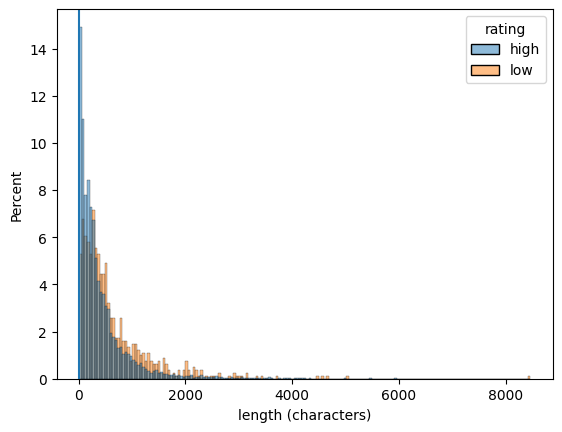

In [164]:
df_ml['length (characters)'] = df_ml['text'].map(len)
df_ml.head(3)

ax = sns.histplot(data=df_ml, hue='rating', x='length (characters)',
                stat='percent',common_norm=False)#, estimator='median',);
ax.axvline()

In [165]:
# Let's take a look at the length of the each text
# We will split on each space, and then get the length
df_ml['length (tokens)'] = df_ml['text'].map( lambda x: len(x.split(" ")))
df_ml['length (tokens)'].describe()

count    6359.000000
mean       85.317345
std       105.261462
min         2.000000
25%        21.000000
50%        52.000000
75%       106.000000
max      1521.000000
Name: length (tokens), dtype: float64

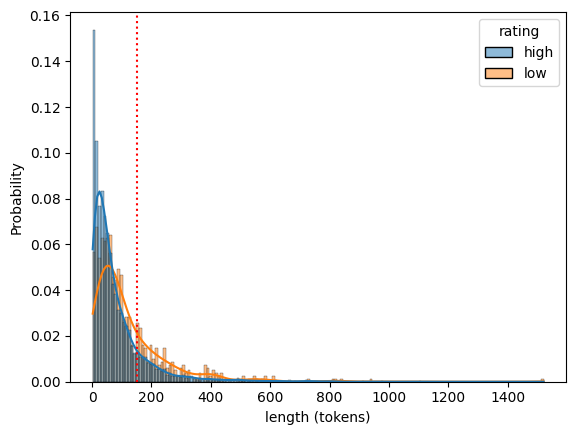

In [166]:
SEQUENCE_LENGTH = 150
ax = sns.histplot(data=df_ml, hue='rating', x='length (tokens)',kde=True,
                stat='probability',common_norm=False)#, estimator='median',);
ax.axvline(SEQUENCE_LENGTH, color='red', ls=":")

In [ ]:
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity

# # Define a function to calculate cosine similarity
# def find_closest_embeddings(embedding):
    
#     return sorted(vector_dict.keys(), key=lambda word: cosine_similarity([vector_dict[word]], [embedding]))

# # Example of finding words similar to 'vacuum' 
# similar_to_vacuum = find_closest_embeddings(vector_dict['vacuum'])[:5]  # Get the top 5 similar words

# # Print the similar words
# print("Words similar to 'vacuum':", similar_to_vacuum)

# # Demonstration of vector arithmetic: 'hate' + 'love' + 'vacuum'
# combined_vector = vector_dict['hate'] + vector_dict['love'] + vector_dict['vacuum']
# similar_to_combined = find_closest_embeddings(combined_vector)[:5]  # Get the top 5 similar words

# # Print the similar words to the combined vector
# print("Words similar to the combination of 'hate', 'love', and 'vacuum':", similar_to_combined)
# # 

In [ ]:

# # Example of finding words similar to 'vacuum' 
# n_results = 5
# demo_word = 'vacuum'
# add_word = 'love'

# similar_to_vacuum = find_closest_embeddings(vector_dict[demo_word])[:n_results]  # Get the top 5 similar words

# # Print the similar words
# print(f"Words similar to '{demo_word}':")
# print(similar_to_vacuum)

# # Demonstration of vector arithmetic: 'hate' + 'love' + 'vacuum'
# combined_vector =vector_dict[add_word] + vector_dict[demo_word]# vector_dict['hate'] + 

# similar_to_combined = find_closest_embeddings(combined_vector)[:n_results]  # Get the top 5 similar words

# # Print the similar words to the combined vector
# print(f"\nWords similar to the combination of {demo_word} + {add_word}")
# print(similar_to_combined)


# Our First Deep Sequence Model

### Combining the 

### Simple RNN

In [167]:
## Create text Vectorization layer
SEQUENCE_LENGTH=50 #BEST=50
EMBED_DIM = 100 # BEST= 200

sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

sequence_vectorizer.adapt(ds_texts)

In [168]:
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()


# Define sequential model with pre-trained vectorization layer and *new* embedding layer
model = Sequential([
    sequence_vectorizer,
    layers.Embedding(input_dim=VOCAB_SIZE,
                              output_dim=EMBED_DIM, 
                              input_length=SEQUENCE_LENGTH)
    ])

In [169]:
def build_rnn_model(text_vectorization_layer):
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = sequence_vectorizer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    model.add(layers.SimpleRNN(32)) #BEST=32
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 50)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 50, 100)           588900    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 593,189
Trainable params: 593,189
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
35/35 [==============================] - 2s 11ms/step - loss: 0.6337 - accuracy: 0.6324 - val_loss: 0.3

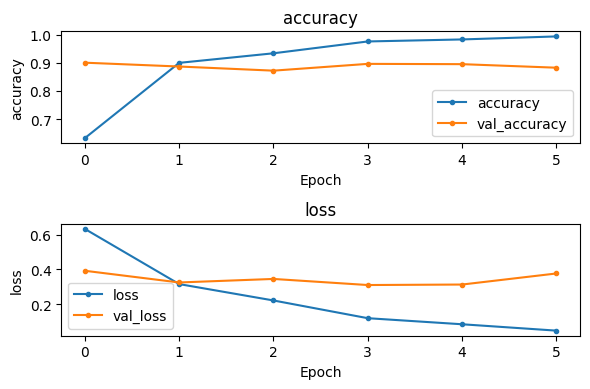

In [170]:
# Build the lstm model and specify the vectorizer
rnn_model = build_rnn_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5),
)
fn.plot_history(history,figsize=(6,4))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       559
           1       1.00      1.00      1.00       559

    accuracy                           1.00      1118
   macro avg       1.00      1.00      1.00      1118
weighted avg       1.00      1.00      1.00      1118



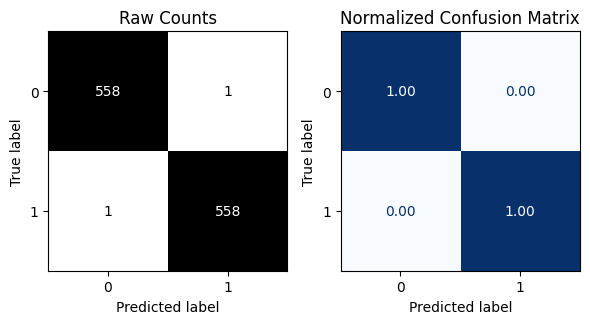


- Evaluating Training Data:
35/35 [==============================] - 0s 2ms/step - loss: 0.0286 - accuracy: 0.9982
{'loss': 0.02858741208910942, 'accuracy': 0.9982110857963562}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       833
           1       0.48      0.89      0.62       121

    accuracy                           0.86       954
   macro avg       0.73      0.87      0.77       954
weighted avg       0.92      0.86      0.88       954



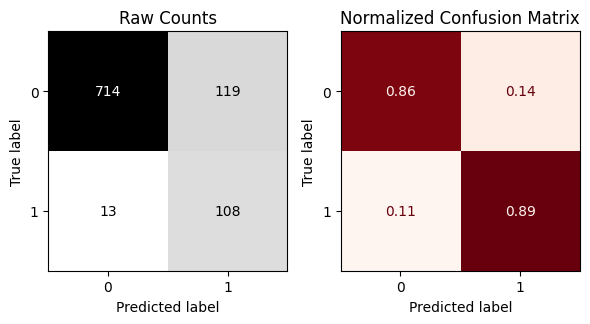


- Evaluating Test Data:
30/30 [==============================] - 0s 2ms/step - loss: 0.4272 - accuracy: 0.8616
{'loss': 0.42724138498306274, 'accuracy': 0.8616352081298828}


In [171]:
# Obtain the results
results = fn.evaluate_classification_network(
    rnn_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

# Next Class

> We will continue with this task and introduce and apply various sequence models.

# APPENDIX - Save for Next Lecture

In [ ]:
## TEMP/EXP - extract embedding matrix

embedding_weights = rnn_model.layers[1].get_weights()[0]
embedding_weights.shape

> - Conceptual example of using the maximum value as final result.
> - Relate to GlovalMaxPooling1D() layer

In [ ]:
# Saving the MAX values (relate to GlobalMaxPooling)
max_vector = np.max((vector_dict['hate'], vector_dict['love'] ,vector_dict['vacuum']), axis=0)
print(max_vector.shape)
max_vector

In [ ]:
# Saving the Average values (relate to GlobalMaxPooling)
avg_vector = np.mean((vector_dict['hate'], vector_dict['love'] ,vector_dict['vacuum']), axis=0)
print(avg_vector.shape)
avg_vector